Data Dictionary

1.	distance_from_dealer - distance of customer from the dealership
2.	sales_source - what channel the car was sold on (eBay, Autotrader,etc)
3.	free_shipping_cost - cost to ship the car to the customer (we offer free shipping)
4.	stock_number - unique id for the car sold
5.  car_class - description of the car. Example - SUV, Luxury
6.  body - body style of the car (sedan, convertible,etc)
7.  color - exterior color
8.  year - year of the car
9.  make - brand of the car (BMW, Ford, etc)
10. model - model of the car (F150, Corvette, etc)
11. mileage - miles driven on the car
12. age - # of days for the car to sell
13. trade_acv - $ amount if customer traded their car in to buy another
14. acquisition_cost - cost for us to acquire the car that was sold
15. reconditioning_cost - cost for us to recondition the car before selling
16. total_cost - total cost to us
17. sale_price - price of the car when it was sold
18. front_gross - profit to us from the sale
19. financing - profit to us if buyer opted to finance with us
20. warranty - profit to us if buyer purchased a warranty
21. insurance - profit to us if buyer purchased insurance
22. other_products - profit to us if buyer purchased other products
23. theft - disregard
24. ultimate - disregard
25. dent/ding - disregard
26. windshield - disregard
27. tire/wheel - disregard
28. roadside - disregard
29. bank_fees - disregard
30. back_gross - Total profit off all add-ons (financing, warranty etc)
31. total_gross - front gross + back gross

In [3654]:
import pandas as pd
import numpy as np
import math
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from patsy import dmatrices, dmatrix
from sklearn.linear_model import Lasso
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import RandomizedPCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.svm import SVC
import matplotlib.pyplot as plt
%matplotlib inline

In [3655]:
df = pd.read_csv('merch_data.csv')
pd.set_option('display.max_rows', 500)

In [3656]:
# clean up column names
df.columns = df.columns.str.replace(' ','_')
df.columns = [x.lower() for x in df.columns]

In [3657]:
# remove feature if null count is above 1000
null_cnts = df.isnull().sum()
headers = []
for x in null_cnts.keys():
    if null_cnts[x]<=2000:
        headers.append(x)

In [3658]:
data = df[headers]

In [3659]:
# fill in null values 
data['free_shipping_cost'] = data['free_shipping_cost'].fillna(0)
data['trade_acv'] = data['trade_acv'].fillna(0)
data['financing'] = data['financing'].fillna(0)
data['warranty'] = data['warranty'].fillna(0)
data['insurance'] = data['insurance'].fillna(0)
data['other_products'] = data['other_products'].fillna(0)
data = data.fillna('missing, missing')

/Users/daniellee/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/daniellee/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/daniellee/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [3660]:
# reduce number of sales sources by grouping into broader groups
def update_sales_source(x):
    if x in('repeat customer','referral','dealer','known other','truecar','craigslist','carfax','repeat','kbb','email'):
        return 'known_other'
    elif x in('unknown','website','drive by'):
        return 'unknown'
    else:
        return x

data['sales_source'] = data.sales_source.apply(lambda x: x.lower())
data['sales_source'] = data.sales_source.apply(update_sales_source)

In [3662]:
# create additional features out of Car Class
data['primary_class'] = data.car_class.apply(lambda x: x.split(', ')[0].split()[0])
data['secondary_class'] = data.car_class.apply(lambda x: x.split(', ')[1].split()[0])

In [3663]:
# create acquisition source feature (where we got the car)
def acq_source(x):
    if str(x)[0] in('1','2'):
        return 'consumer_trade'
    elif str(x)[0] in('3','4','5'):
        return 'auction_purchase'
    elif str(x)[0] == '7':
        return 'dealer_purchase'
    elif str(x)[0] in('8','9'):
        return 'consumer_purchase'
    
data['acq_source'] = data.stock_number.apply(acq_source)

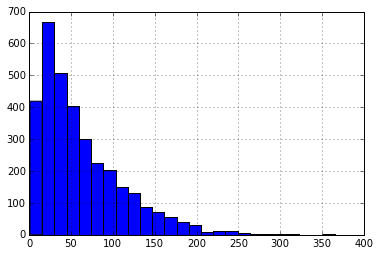

In [3664]:
# see how age of sale is distributed
data.age.hist(bins=25)

In [3665]:
# based on visualization, group ages into buckets
def age_groups(x):
    if x <= 35:
        return 'fast'
    elif x <=60:
        return 'good'
    elif x <=90:
        return 'average'
    else:
        return 'poor'

data['age_group'] = data.age.apply(age_groups)

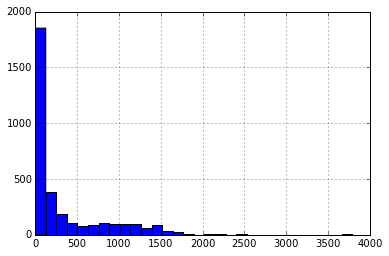

In [3666]:
# see how distance from dealership is distributed
data.distance_from_dealer.hist(bins=30)

In [3667]:
# based on visualization, distance from dealership into buckets
def dealer_range(x):
    if x <= 100:
        return '0-100'
    elif x <= 200:
        return '101-200'
    else:
        return '201+'
    
data['dealer_range'] = data.distance_from_dealer.apply(dealer_range)

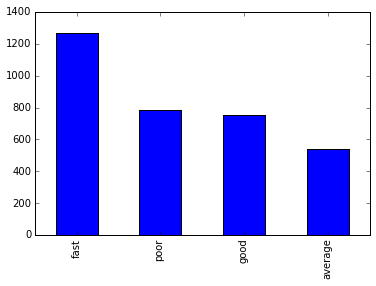

In [3668]:
# see how our sales are distributed by age group
data.age_group.value_counts().plot(kind='bar')

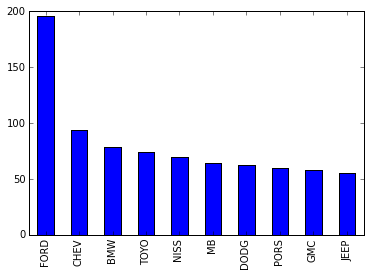

In [3669]:
# take a look at sales by make of car for cars that sold fast
data[data.age_group == 'fast'].make.value_counts().head(10).plot(kind='bar')

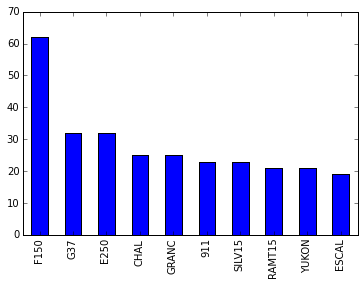

In [3670]:
# sales by car model for cars that sold fast
data[data.age_group == 'fast'].model.value_counts().head(10).plot(kind='bar')

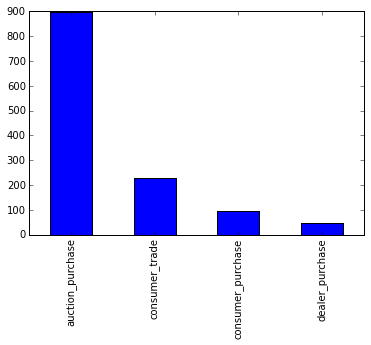

In [3672]:
# distribution of acquisition source for fast sellers
data[data.age_group == 'fast'].acq_source.value_counts().plot(kind='bar')

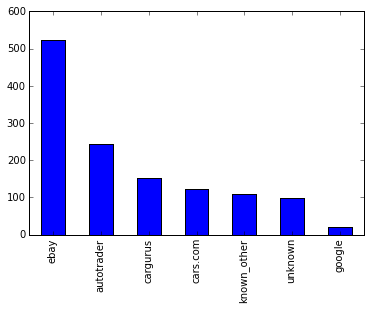

In [3673]:
# distribution of sales source for fast sellers
data[data.age_group == 'fast'].sales_source.value_counts().plot(kind='bar')

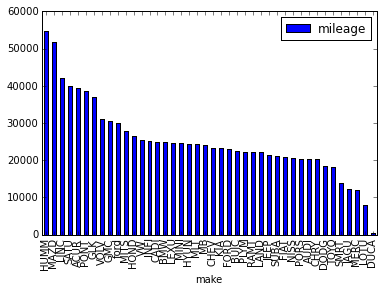

In [3674]:
# average mileage by make for fast sellers
makes = data[['make','mileage','age_group']]
makes = makes[makes.age_group == 'fast']
makes = makes[['make','mileage']]
makes_group = makes.groupby('make')
avg_mileage = makes_group.mean().sort('mileage', ascending=False)
avg_mileage.plot(kind='bar')

In [3676]:
# get features that are ints and floats
num_features = []
for x in data.columns:
    if data[x].dtype in ('int64','float64'):
        num_features.append(x)

num_features

['distance_from_dealer',
 'free_shipping_cost',
 'year',
 'mileage',
 'age',
 'trade_acv',
 'acquisition_cost',
 'reconditioning_cost',
 'total_cost',
 'sale_price',
 'front_gross',
 'financing',
 'warranty',
 'insurance',
 'other_products',
 'back_gross',
 'total_gross']

In [3733]:
# remove age from features since we're predicting this
# remove features that we know AFTER the car is sold i.e. gross profit etc...
#remove total cost since this is made up of acq and recon cost

num_features = ['distance_from_dealer', 'sale_price',
 'year',
 'mileage',
 'acquisition_cost',
 'reconditioning_cost']

In [3734]:
tweaked_num = ' + '.join(num_features)

In [3735]:
# get features that are strings
obj_features = []
for x in data.columns:
    if data[x].dtype == 'object':
        obj_features.append(x)
        
obj_features

['sales_source',
 'stock_number',
 'car_class',
 'body',
 'color',
 'make',
 'model',
 'primary_class',
 'secondary_class',
 'acq_source',
 'age_group',
 'dealer_range']

In [3736]:
# remove age group since we're also trying to predict this
# remove features like stock_number and car_class which have more granular features built off of them
#'sales_source' since this is known after the sale
obj_features = [
 'body',
 'color',
 'make',
 'model',
 'acq_source',
 'primary_class',
 'secondary_class']

In [3737]:
tweaked_obj = ') + C('.join(obj_features)
tweaked_obj = "C("+ tweaked_obj + ")"

In [3738]:
y, X = dmatrices('age ~ 0 +' + tweaked_num + '+' + tweaked_obj , data, return_type = 'dataframe')
#flatter y to a list
y = np.ravel(y)

In [3739]:
# split data into 80/20 train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [3740]:
# fit data to the model first try
ls = Lasso(max_iter=100)
ls.fit(X_train, y_train) #<- predicting y given X
np.abs(cross_val_score(ls, X_test, y_test, scoring='mean_absolute_error', cv=10).mean())

33.708720440131202

In [3741]:
# scale data to improve lasso cv score
# scaling equalizes the rate variables move and removes the units - addresses outliers
scaler = StandardScaler(copy=True)
Xtrain_scaled = scaler.fit(X_train).transform(X_train)
ytrain_scaled = scaler.fit(y_train).transform(y_train)
Xtest_scaled = scalerx.fit(X_test).transform(X_test)
ytest_scaled = scalery.fit(y_test).transform(y_test)

In [3742]:
# fit data to the model 2nd try
# result is 0.8 sd off from mean
ls_scale = Lasso(max_iter=100) #scales features
ls_scale.fit(Xtrain_scaled, ytrain_scaled) #<- predicting y given X
np.abs(cross_val_score(ls, Xtest_scaled, ytest_scaled, scoring='mean_absolute_error', cv=10).mean())

0.77720356312211403

In [3743]:
# range of std for data set
scaler_X = StandardScaler(copy=True)
data_scaled = scaler.fit(data.age).transform(data.age)
print data_scaled.max()
print data_scaled.min()

6.086284465
-1.22064988265


In [3744]:
data.age.describe()
# std x result to get range of accuracy in years
49.96*0.77720356312211403

38.82909001358082

In [3745]:
#make a dematrix w the predicting data and put into .predict
# prediction =dematrix(prediction_data)
# predictionscaled = scalerx.fit(prediction)
# lscaled.predict(predictionscaled)

In [3746]:
d = {'features': X.columns, 'coefficients': ls.coef_}
coeffs = pd.DataFrame(d)

In [3747]:
# run rf to predict age_group
# fit train data to model but use test for cv
rf = RandomForestRegressor(n_estimators = 100)
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [3748]:
#why cant this handle accuracy? -bc variables are continuous
#why is n_jobs = -1
np.abs(cross_val_score(rf, X_test, y_test, scoring='mean_absolute_error', cv=10, n_jobs=-1).mean())

36.605091135232939

In [3749]:
# feature importances
# the higher, the more important the feature
d = {'importance': rf.feature_importances_}
imp = pd.DataFrame(d, index=X.columns).sort('importance', ascending =False)
imp

,importance
reconditioning_cost,0.107
sale_price,0.098
distance_from_dealer,0.096
acquisition_cost,0.091
mileage,0.084
year,0.031
C(color)[T.Red],0.010
C(acq_source)[T.consumer_trade],0.010
C(color)[T.White],0.010
C(color)[T.Blue],0.009


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x21c4a5d50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x24942c3d0>]], dtype=object)

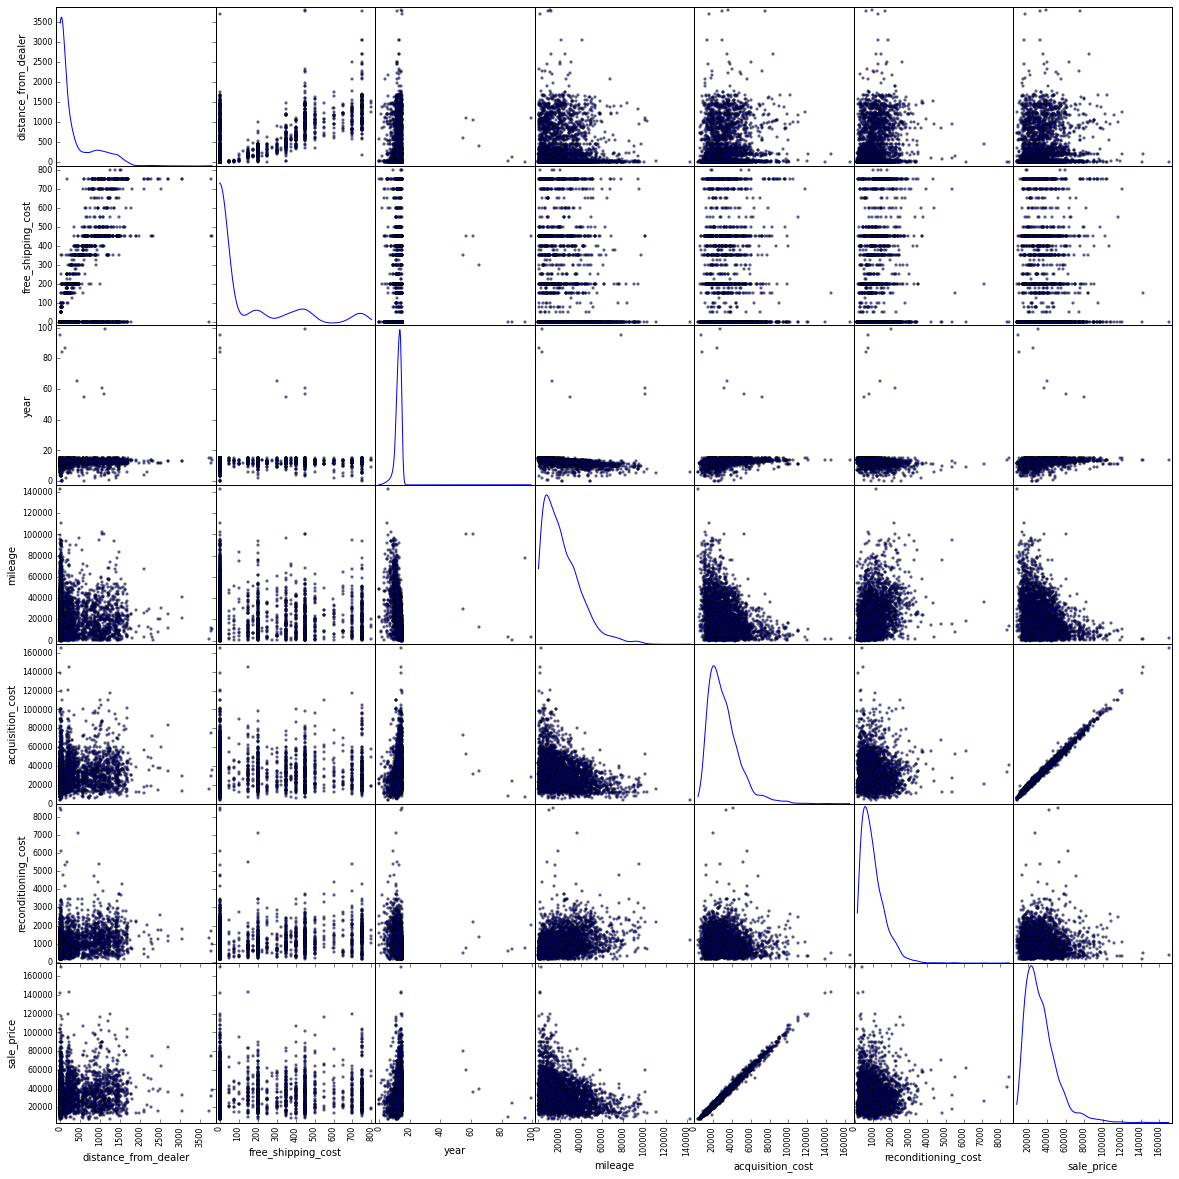

In [3420]:
num_data = data[num_features]
num_data.corr()
pd.tools.plotting.scatter_matrix(num_data, figsize=(20,20), diagonal='kde')